# Setup

In [1]:
import numpy as np
import scipy.io as sio
import math
import matplotlib.pyplot as plt
from matplotlib import image
import glob
from scipy.stats.stats import pearsonr
import mat73
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score


In [2]:
# which datasets to read and write

do_indian_pines = True 
do_salient_objects = True
do_plastic_flakes = True
do_soil_moisture = True


## Define functions

In [3]:
# reward functions

def calculate_correlations(data, num_bands_originally, num_bands_kept):
    
    selected_bands = np.random.randint(0,num_bands_originally,num_bands_kept)
    corr_sum = 0
    for i in selected_bands:
        for j in selected_bands:
            
            corr_sum += pearsonr(data[:, i], 
                                 data[:, j])[0]
            
    return corr_sum/(len(selected_bands)**2)


def calculate_mutual_infos(data, num_bands_originally, num_bands_kept):
    
    selected_bands = np.random.randint(0,num_bands_originally,num_bands_kept)
    normalized_mutual_info_score_sum = 0
    for i in selected_bands:
        for j in selected_bands:
            
            normalized_mutual_info_score_sum += normalized_mutual_info_score(data[:, i],
                                                                             data[:, j])
            
    return normalized_mutual_info_score_sum/(len(selected_bands)**2)


In [4]:
## dataset loading
np.random.seed(seed=42)

def load_datasets(Dataset, write=False):
    
    np.random.seed(seed=42)
    
    if Dataset == 'SM':
        data_path = 'soil_moisture_regression/soilmoisture_dataset.csv'
        # data read and reshape
        df = pd.read_csv(data_path)
        hypbands = []
        for col in df.columns:
            try:
                int(col)
            except Exception:
                continue
            hypbands.append(col)
        data_hsi = df[hypbands]
        gt_hsi = df['soil_moisture']
        data = np.array(data_hsi)
        data = ((data - data.min()) * (1/(data.max() - data.min()) * 255)).astype('uint8')
        gt = np.array(gt_hsi)
    
 
    if Dataset == 'IN':
        data_path = 'land_cover_classification/indian_pines/'
        # data read and reshape
        mat_data = sio.loadmat(data_path + 'Indian_pines_corrected.mat')
        mat_gt = sio.loadmat(data_path + 'Indian_pines_gt.mat')
        data_hsi = mat_data['indian_pines_corrected']
        gt_hsi = mat_gt['indian_pines_gt']
        data = data_hsi.reshape(
            np.prod(data_hsi.shape[:2]), np.prod(data_hsi.shape[2:]))
        data = ((data - data.min()) * (1/(data.max() - data.min()) * 255)).astype('uint8')
        gt = gt_hsi.reshape(np.prod(gt_hsi.shape[:2]), )
    
        # remove NA class (label = 0)
        gt = gt[np.where(gt!=0)[0]]
        data = data[np.where(gt!=0)[0], :]
        
        
    if Dataset == 'SO':
        data_path = 'salient_objects_segmentation/HS-SOD/'
        hsi_paths = glob.glob(data_path + 'hyperspectral/*.mat')
        gt_paths = []
        for i in range(len(hsi_paths)):
            num = hsi_paths[i].split('.')[0].split('/')[-1]
            gt_paths.append(data_path + f'ground_truth/{num}.jpg')
            
        # sample 5 paths for experiment
        indices = np.random.randint(0, 60, 5)
        hsi_paths = np.array(hsi_paths)[indices]
        gt_paths = np.array(gt_paths)[indices]
        gt_write_paths = []
        data_write_paths = []
        
        print('\nHypercube write paths...')
        for path in hsi_paths:
            num = path.split('.')[0].split('/')[-1]
            data_write_tmp = f'../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/{num}.npy'
            data_write_paths.append(data_write_tmp)
            print(f'Saving {path} to  ->  {data_write_tmp}')     
        
        print('\nLabel write paths...')
        for path in gt_paths:
            num = path.split('.')[0].split('/')[-1]
            gt_write_tmp = f'../HyperSpectralRL/data/salient_objects/gt_labels/{num}.npy'
            gt_write_paths.append(gt_write_tmp)            
            print(f'Saving {path} to  ->  {gt_write_tmp}')
            
        # read samples
        data = []
        data_hsi = []
        gt_hsi = []
        gt = []
        for path in hsi_paths:
            mat_data = mat73.loadmat(path)  
            mat_data = mat_data['hypercube'].astype(np.uint8)
            data_hsi.append(mat_data)
            data_tmp = mat_data.reshape(
                np.prod(mat_data.shape[:2]), np.prod(mat_data.shape[2:]))
            data_tmp = ((data_tmp - data_tmp.min()) * (1/(data_tmp.max() - data_tmp.min()) * 255)).astype('uint8')
            data.append(data_tmp)
            
        for path in gt_paths:
            label_mask = image.imread(path)
            gt_hsi.append(label_mask[:,:,0])
            gt_tmp = label_mask[:,:,0].reshape(np.prod(label_mask[:,:,0].shape[:2]), )
            gt_tmp[gt_tmp!=0] = 1
            gt.append(gt_tmp.astype(np.uint8))
        
        if write:
            for itr, img in enumerate(data):
                np.save(data_write_paths[itr], img)
            for itr, img in enumerate(gt):
                np.save(gt_write_paths[itr], img)
              
            
    if Dataset == 'PF':
        data_path = 'plastic_flakes_segmentation/HSOD-ICIP-2022/baselines_cropped/training/'
        hsi_paths = glob.glob(data_path + 'crop/*.npz')
        gt_paths = []
        for i in range(len(hsi_paths)):
            num = hsi_paths[i].split('.')[0].split('/')[-1]
            gt_paths.append(data_path + f'annot/{num}.npy')
            
        # sample 5 paths for experiment
        indices = np.random.randint(0, 11, 5)
        hsi_paths = np.array(hsi_paths)[indices]
        gt_paths = np.array(gt_paths)[indices]
        gt_write_paths = []
        data_write_paths = []
        
        print('\nHypercube write paths...')
        for path in hsi_paths:
            num = path.split('.')[0].split('/')[-1]
            data_write_tmp = f'../HyperSpectralRL/data/plastic_flakes/hyperspectral_imagery/{num}.npy'
            data_write_paths.append(data_write_tmp)
            print(f'Saving {path} to  ->  {data_write_tmp}')     
        
        print('\nLabel write paths...')
        for path in gt_paths:
            num = path.split('.')[0].split('/')[-1]
            gt_write_tmp = f'../HyperSpectralRL/data/plastic_flakes/gt_labels/{num}.npy'
            gt_write_paths.append(gt_write_tmp)            
            print(f'Saving {path} to  ->  {gt_write_tmp}')
            
        # read samples
        data = []
        data_hsi = []
        gt_hsi = []
        gt = []
        for path in hsi_paths:
            raw_data = np.load(path) 
            arr = raw_data['raw']
            new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
            data_hsi.append(new_arr)
            data_tmp = new_arr.reshape(
                np.prod(new_arr.shape[:2]), np.prod(new_arr.shape[2:]))
            data.append(data_tmp)
            
        for path in gt_paths:
            label_mask = np.load(path)
            gt_hsi.append(label_mask)
            gt_tmp = label_mask.reshape(np.prod(label_mask.shape[:2]), )
            gt.append(gt_tmp.astype(np.uint8))
        
        if write:
            for itr, img in enumerate(data):
                np.save(data_write_paths[itr], img)
            for itr, img in enumerate(gt):
                np.save(gt_write_paths[itr], img)
            
        
    return data_hsi, gt_hsi, data, gt



Hypercube write paths...
Saving plastic_flakes_segmentation/HSOD-ICIP-2022/baselines_cropped/training/crop/try_3_1.npz to  ->  ../HyperSpectralRL/data/plastic_flakes/hyperspectral_imagery/try_3_1.npy
Saving plastic_flakes_segmentation/HSOD-ICIP-2022/baselines_cropped/training/crop/try_2_1.npz to  ->  ../HyperSpectralRL/data/plastic_flakes/hyperspectral_imagery/try_2_1.npy
Saving plastic_flakes_segmentation/HSOD-ICIP-2022/baselines_cropped/training/crop/try_8_1.npz to  ->  ../HyperSpectralRL/data/plastic_flakes/hyperspectral_imagery/try_8_1.npy
Saving plastic_flakes_segmentation/HSOD-ICIP-2022/baselines_cropped/training/crop/try_1_1.npz to  ->  ../HyperSpectralRL/data/plastic_flakes/hyperspectral_imagery/try_1_1.npy
Saving plastic_flakes_segmentation/HSOD-ICIP-2022/baselines_cropped/training/crop/try_5_1.npz to  ->  ../HyperSpectralRL/data/plastic_flakes/hyperspectral_imagery/try_5_1.npy

Label write paths...
Saving plastic_flakes_segmentation/HSOD-ICIP-2022/baselines_cropped/training/

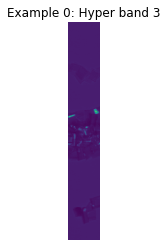

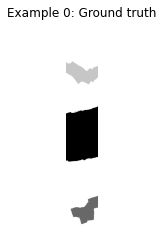

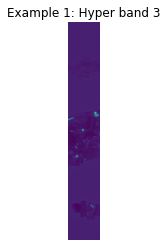

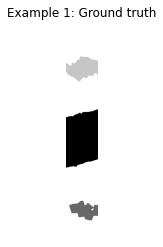

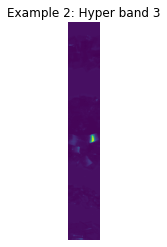

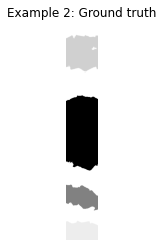

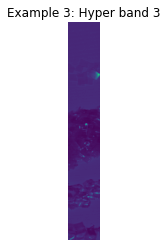

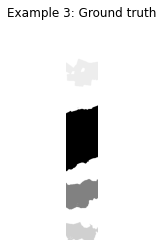

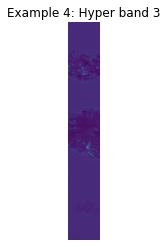

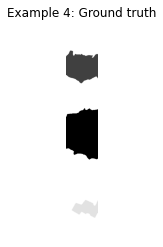




Correlation reward for random 10 bands, x5 runs: 0.9458352977761877
Normalized mutual information reward for random 10 bands, x5 runs: 0.6485442833510298


<Figure size 432x288 with 0 Axes>

In [8]:
if do_plastic_flakes:
    data_hsi, gt_hsi, data, gt = load_datasets(
        'PF', write=True)
    
    print('\nDataset info...')
    print('The shape of the original imagery:', data_hsi[0].shape)
    print('The shape of the original labels:', gt_hsi[0].shape)
    print('The shape of the flattened imagery:', data[0].shape)
    print('The shape of the flattened labels:', gt[0].shape)
    print('\n')
    for i in range(len(data_hsi)):
        
        # plot a sample band
        plt.imshow(data_hsi[i][:,:,3])
        plt.title(f'Example {i}: Hyper band 3')
        plt.axis("off")
        plt.show()
        plt.figure()
        # plot the labels
        plt.imshow(gt_hsi[i], cmap = 'Greys')
        plt.title(f'Example {i}: Ground truth')
        plt.axis("off")
        plt.show()
        plt.figure()
        print('\n')
    
    # rewards
    correlations = []
    for i in range(5):
        correlations.append(calculate_correlations(data[2], 224, 10))
    print('\nCorrelation reward for random 10 bands, x5 runs:', np.mean(correlations))
    
    mis = []
    for i in range(5):
        mis.append(calculate_mutual_infos(data[2], 224, 10))
    print('Normalized mutual information reward for random 10 bands, x5 runs:', np.mean(mis))     


Hypercube write paths...
Saving salient_objects_segmentation/HS-SOD/hyperspectral/0051.mat to  ->  ../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/0051.npy
Saving salient_objects_segmentation/HS-SOD/hyperspectral/0037.mat to  ->  ../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/0037.npy
Saving salient_objects_segmentation/HS-SOD/hyperspectral/0082.mat to  ->  ../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/0082.npy
Saving salient_objects_segmentation/HS-SOD/hyperspectral/0077.mat to  ->  ../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/0077.npy
Saving salient_objects_segmentation/HS-SOD/hyperspectral/0052.mat to  ->  ../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/0052.npy

Label write paths...
Saving salient_objects_segmentation/HS-SOD/ground_truth/0051.jpg to  ->  ../HyperSpectralRL/data/salient_objects/gt_labels/0051.npy
Saving salient_objects_segmentation/HS-SOD/ground_truth/0037.jpg to  ->  ../HyperSpectralRL/dat

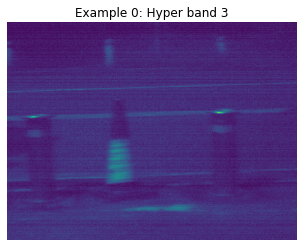

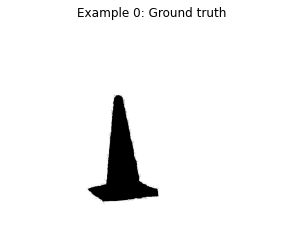

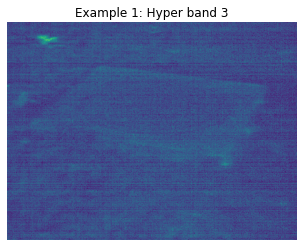

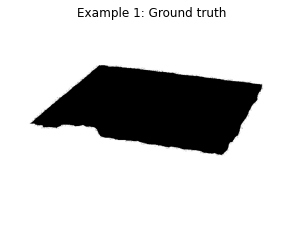

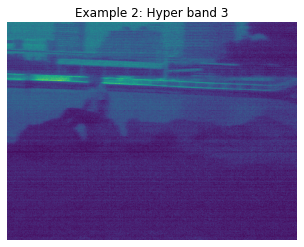

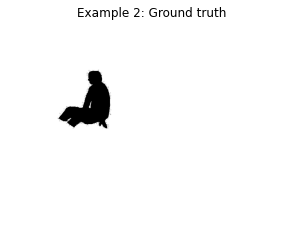

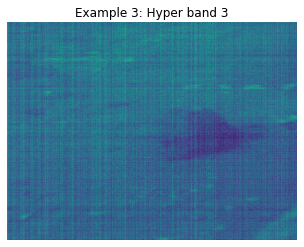

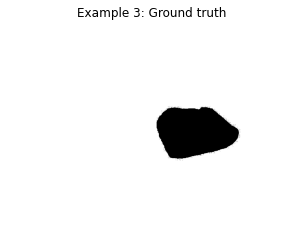

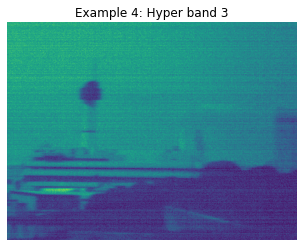

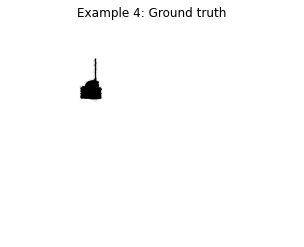




Correlation reward for random 10 bands, x5 runs: 0.16568944228109936
Normalized mutual information reward for random 10 bands, x5 runs: 0.2013314940691746


<Figure size 432x288 with 0 Axes>

In [9]:
if do_salient_objects:
    data_hsi, gt_hsi, data, gt = load_datasets(
        'SO', write=True)
    
    print('\nDataset info...')
    print('The shape of the original imagery:', data_hsi[0].shape)
    print('The shape of the original labels:', gt_hsi[0].shape)
    print('The shape of the flattened imagery:', data[0].shape)
    print('The shape of the flattened labels:', gt[0].shape)
    print('The number of different classes:', len(np.unique(gt[0])))
    
    for i in range(len(data_hsi)):
        
        # plot a sample band
        plt.imshow(data_hsi[i][:,:,3])
        plt.title(f'Example {i}: Hyper band 3')
        plt.axis("off")
        plt.show()
        plt.figure()
        # plot the labels
        plt.imshow(gt_hsi[i], cmap = 'Greys')
        plt.title(f'Example {i}: Ground truth')
        plt.axis("off")
        plt.show()
        plt.figure()
        print('\n')
    
    # rewards
    correlations = []
    for i in range(5):
        correlations.append(calculate_correlations(data[2], 81, 10))
    print('\nCorrelation reward for random 10 bands, x5 runs:', np.mean(correlations))
    
    mis = []
    for i in range(5):
        mis.append(calculate_mutual_infos(data[2], 81, 10))
    print('Normalized mutual information reward for random 10 bands, x5 runs:', np.mean(mis)) 

The shape of the original imagery: (145, 145, 200)
The shape of the original labels: (145, 145) 

The shape of the flattened imagery: (10249, 200)
The shape of the flattened labels: (10249,)
The number of different classes: 16


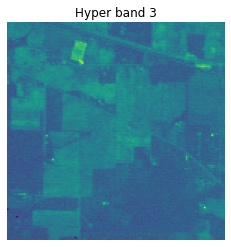

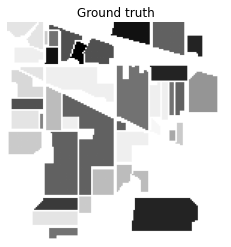


Correlation reward for random 10 bands, x5 runs: 0.4315501464716217
Normalized mutual information reward for random 10 bands, x5 runs: 0.31474884133492903


<Figure size 432x288 with 0 Axes>

In [10]:
if do_indian_pines:
    write = True
    data_hsi, gt_hsi, data, gt = load_datasets(
        'IN')
    
    print('The shape of the original imagery:', data_hsi.shape)
    print('The shape of the original labels:', gt_hsi.shape, '\n')
    print('The shape of the flattened imagery:', data.shape)
    print('The shape of the flattened labels:', gt.shape)
    print('The number of different classes:', len(np.unique(gt)))
    
    # plot a sample band
    plt.imshow(data_hsi[:,:,3]/np.max(data_hsi[:,:,3]*255))
    plt.title(f'Hyper band 3')
    plt.axis("off")
    plt.show()
    plt.figure()
    # plot the labels
    plt.imshow(gt_hsi, cmap='Greys')
    plt.title(f'Ground truth')
    plt.axis("off")
    plt.show()
    plt.figure()
    
    # rewards
    correlations = []
    for i in range(5):
        correlations.append(calculate_correlations(data, 200, 10))
    print('\nCorrelation reward for random 10 bands, x5 runs:', np.mean(correlations))
    
    mis = []
    for i in range(5):
        mis.append(calculate_mutual_infos(data, 200, 10))
    print('Normalized mutual information reward for random 10 bands, x5 runs:', np.mean(mis))    
    
    if write:
        np.save('../HyperSpectralRL/data/indian_pines/hyperspectral_imagery/indian_pines_corrected.npy', data.astype(np.uint8))
        np.save('../HyperSpectralRL/data/indian_pines/gt_labels/indian_pines_gt.npy', gt.astype(np.uint8))
        

In [11]:
if do_soil_moisture:
    write = True
    data_hsi, gt_hsi, data, gt = load_datasets(
        'SM')
    print('\nDataset info...')
    print('The shape of the original imagery:', data_hsi.shape)
    print('The shape of the original labels:', gt_hsi.shape)
    print('The shape of the flattened imagery:', data.shape)
    print('The shape of the flattened labels:', gt.shape)
    
    # rewards
    correlations = []
    for i in range(5):
        correlations.append(calculate_correlations(data, 125, 10))
    print('\nCorrelation reward for random 10 bands, x5 runs:', np.mean(correlations))
    
    mis = []
    for i in range(5):
        mis.append(calculate_mutual_infos(data, 125, 10))
    print('Normalized mutual information reward for random 10 bands, x5 runs:', np.mean(mis))
    
    if write:
        np.save('../HyperSpectralRL/data/soil_moisture/hyperspectral_imagery/soil_moisture_hyper.npy', data)
        np.save('../HyperSpectralRL/data/soil_moisture/gt_labels/soil_moisture_gt.npy', gt)
        


Dataset info...
The shape of the original imagery: (679, 125)
The shape of the original labels: (679,)
The shape of the flattened imagery: (679, 125)
The shape of the flattened labels: (679,)

Correlation reward for random 10 bands, x5 runs: 0.987287975201163
Normalized mutual information reward for random 10 bands, x5 runs: 0.6833058067504192
